In [5]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [46]:
import pandas as pd

df = pd.read_csv("Joules_of_Siam_Data - Dataset_Strech.csv")
df.head()

,Year,Month,Population,Temperature,CPI,Peak
0,2022,12,66.09000,26.300000,106.470000,14552.5
1,2022,11,66.08333,26.249167,106.470000,15260.8
2,2022,10,66.07667,26.198333,106.470000,16485.3
3,2022,9,66.07000,26.147500,109.520000,16681.1
4,2022,8,66.06333,26.096667,108.503333,16293.1


In [47]:
df.shape

(252, 6)

In [48]:
df['Date'] = df['Year'].astype(str) + '-' + df['Month'].astype(str)

In [49]:
X = df[['Date','Peak']]
X.head()

,Date,Peak
0,2022-12,14552.5
1,2022-11,15260.8
2,2022-10,16485.3
3,2022-9,16681.1
4,2022-8,16293.1


In [50]:
X = X.iloc[::-1]
X.head()

In [51]:
X.set_index('Date', inplace=True)

In [54]:
X.head()

,Peak
Date,
2002-1,27124.7
2002-2,27832.7
2002-3,27041.9
2002-4,27808.0
2002-5,28951.8


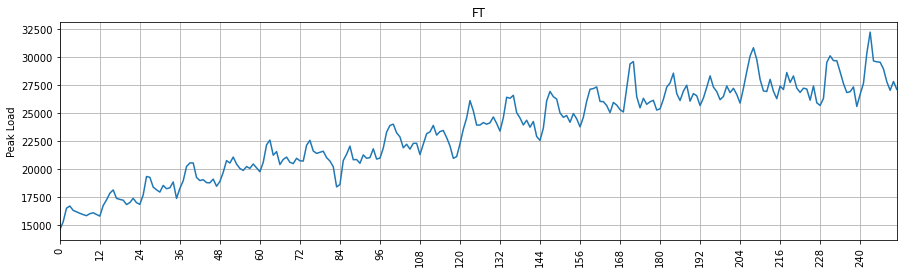

In [55]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4))
plt.title('FT')
plt.ylabel('Peak Load')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Peak'])
plt.xticks(df.index[::12], rotation=90)
plt.show()

In [56]:
y = df['Peak'].values.astype(float)

test_size = 12
window_size = 12

train_set = y[:-test_size]
test_set  = y[-test_size:]

print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

Train: 240
Test:  12


In [32]:
scaler = MinMaxScaler(feature_range=(-1, 1))

train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

print(f'First item, original: {train_set[0]}')
print(f'First item, scaled: {train_norm[0]}')

First item, original: 14552.5
First item, scaled: [-1.]


In [33]:
train_norm = torch.FloatTensor(train_norm).view(-1)

def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [34]:
train_data = input_data(train_norm,window_size)

print(f'Train_data: {len(train_data)}')

Train_data: 228


In [35]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=64,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]
    
torch.manual_seed(101)
model = LSTMnetwork()
model

LSTMnetwork(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [36]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [37]:
epochs = 50

for i in range(epochs):
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        # apply the model
        y_pred = model(seq)

        # update parameters
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    if (i+1) % 10 == 0:
        # OPTIONAL print statement
        print(f'{i+1} of {epochs} epochs completed')

1 of 50 epochs completed
11 of 50 epochs completed
21 of 50 epochs completed
31 of 50 epochs completed
41 of 50 epochs completed


In [63]:
future = 12 #months
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())
        
# preds[window_size:]

In [64]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions.shape

(12, 1)

In [79]:
x = np.arange('2022-01', '2023-01', dtype='datetime64[M]') #.astype('datetime64[D]')
x.shape

(12,)

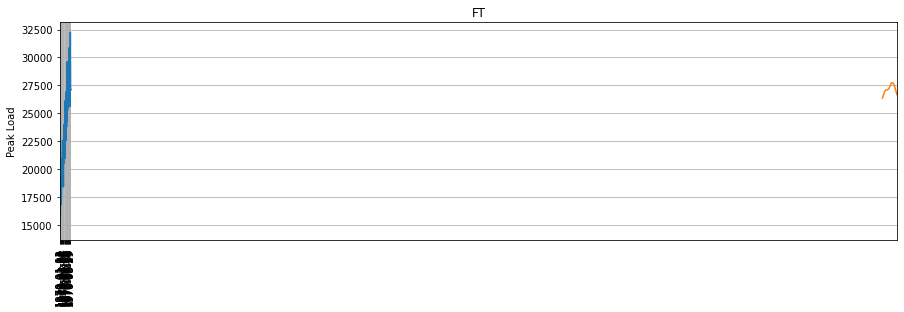

In [80]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4))
plt.title('FT')
plt.ylabel('Peak Load')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Peak'])
plt.plot(x,true_predictions)
plt.xticks(df.index[::12], rotation=90)
plt.show()

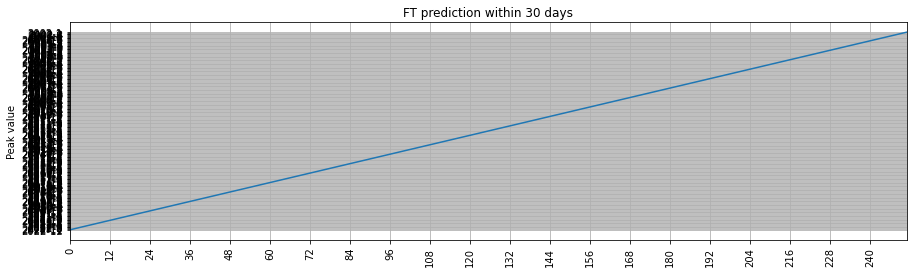

In [59]:
# # x = np.arange(342,372)
# # x = np.arange('2002-01', '2022-12', dtype='datetime64[M]').astype('datetime64[D]')

# plt.figure(figsize=(15,4))
# plt.title('FT prediction within 30 days')
# plt.ylabel('Peak value')
# plt.grid(True)
# plt.autoscale(axis='x',tight=True)
# plt.plot(df['Date'])
# # plt.plot(x,true_predictions)
# plt.xticks(df.index[::12], rotation=90)
# plt.show()

In [58]:
# fig = plt.figure(figsize=(12,4))
# plt.title('FT')
# plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
# plt.grid(True)
# plt.autoscale(axis='x',tight=True)
# fig.autofmt_xdate()
# plt.plot(df['FT']['2020-01':])
# plt.plot(x, true_predictions)
# plt.show()